Горохов Владислав, ПМИ 433

Творческое задание по предмету "Технологии машинного обучения"

# Сегментация снимков легких

Подключаем Google-Диск:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Импортируем необходимые библиотеки:

In [2]:
import keras
import numpy as np
import tensorflow as tf
from imutils import paths
from keras.preprocessing.image import ImageDataGenerator
from keras.integration_test.preprocessing_test_utils import preprocessing
from keras import layers
from keras.callbacks import ModelCheckpoint
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
# функция для изменения размера изображения
def img_resize(img, size=(256, 256)):
    return cv2.resize(img, size)

Получаем из указанных папок имена всех соответствующих файлов:

In [4]:
img_path = os.path.join('/content/drive/MyDrive/Segmentation/CXR_png')
img_names = os.listdir(img_path)
img_names = [file_name.split('.png')[0] for file_name in img_names]  # имена файлов изображений

len(img_names)

792

In [5]:
mask_path = os.path.join('/content/drive/MyDrive/Segmentation/masks')
mask_names = os.listdir(mask_path)
mask_names = [file_name.split('.png')[0] for file_name in mask_names]  # имена файлов масок

len(mask_names)

704

In [6]:
img_w_mask_names = [file_name.split('_mask')[0] for file_name in mask_names]  # имена файлов изображений, для которых есть маски

In [7]:
existing_imgs = [file_name for file_name in img_w_mask_names if file_name in img_names]  # имена файлов изображений, для которых есть и снимок, и маска

len(existing_imgs)

696

In [8]:
existing_masks = [file_name + '_mask' for file_name in existing_imgs if file_name[0] == 'C'] + \
                 [file_name for file_name in existing_imgs if file_name[0] != 'C']  # имена файлов масок, для которых есть снимки

len(existing_masks)

696

Массив изображений легких:

In [9]:
X = np.array([np.array(np.stack((img_resize(cv2.imread(os.path.join(img_path, file_name) + '.png', 0)), ), axis=-1)) for file_name in existing_imgs])

In [10]:
X.shape

(696, 256, 256, 1)

Массив масок:

In [11]:
y = np.array([np.array(np.stack((img_resize(cv2.imread(os.path.join(mask_path, file_name) + '.png', 0)), ), axis=-1)) for file_name in existing_masks])

In [12]:
y.shape

(696, 256, 256, 1)

Проведем аугментацию данных для увеличения имеющегося набора:

In [13]:
X_flip = np.flip(X , axis=2)
y_flip = np.flip(y, axis=2)

X = np.append(X, X_flip, axis=0)
y = np.append(y, y_flip, axis=0)

In [14]:
print(X.shape)
print(y.shape)

(1392, 256, 256, 1)
(1392, 256, 256, 1)


Разбиваем набор на обучающую и валидационную выборки:

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

Cтандартизируем входные значения изображений и задаем пороги для разбиения на классы 0 и 1:

In [16]:
X_train, X_valid = X_train / 255., X_valid / 255.

y_train = (y_train / 255. > 0.5).astype(int)
y_valid = (y_valid / 255. > 0.5).astype(int)

Задаем архитектуру нейронной сети:

In [17]:
input_shape = (256, 256, 1)

In [18]:
inputs = layers.Input(shape=input_shape)

c0 = layers.Conv2D(64, activation='relu', kernel_size=(3, 3), padding='same', name='C0')(inputs)
Drop = layers.Dropout(0.1)(c0)
c1 = layers.Conv2D(64, activation='relu', kernel_size=(3, 3), padding='same', name='C1')(Drop)  
c2 = layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_1')(c1)

c3 = layers.Conv2D(128, activation='relu', kernel_size=(3, 3), padding='same', name='C3')(c2)
Drop = layers.Dropout(0.1)(c3)
c4 = layers.Conv2D(128, activation='relu', kernel_size=(3, 3), padding='same', name='C4')(Drop) 
c5 = layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_2')(c4)

c6 = layers.Conv2D(256, activation='relu', kernel_size=(3, 3), padding='same', name='C6')(c5)
Drop = layers.Dropout(0.2)(c6)
c7 = layers.Conv2D(256, activation='relu', kernel_size=(3, 3), padding='same', name='C7')(Drop)  
c8 = layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_3')(c7) 

c9 = layers.Conv2D(512, activation='relu', kernel_size=(3, 3), padding='same',  name='C9')(c8)
Drop = layers.Dropout(0.2)(c9)
c10 = layers.Conv2D(512, activation='relu', kernel_size=(3, 3), padding='same', name='C10')(Drop)  
c11 = layers.MaxPool2D(pool_size=(2, 2), name='MaxPool_4')(c10)

c12 = layers.Conv2D(1024, activation='relu', kernel_size=(3, 3), padding='same', name='C12')(c11)
Drop = layers.Dropout(0.3)(c12)
c13 = layers.Conv2D(1024, activation='relu', kernel_size=(3, 3), padding='same', name='C13')(Drop)


t01 = layers.Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding='same', name='Transpose_T01')(c13)
concat01 = layers.concatenate([t01, c10], axis=3, name='Concat_1')

c14 = layers.Conv2D(512, activation='relu', kernel_size=(3, 3), padding='same', name='C14')(concat01)
Drop = layers.Dropout(0.3)(c14)
c15 = layers.Conv2D(512, activation='relu', kernel_size=(3, 3), padding='same', name='C15')(Drop)

t02 = layers.Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding='same', name='Transpose_T02')(c15)
concat02 = layers.concatenate([t02, c7], axis=3, name='Concat_2')

c16 = layers.Conv2D(256, activation='relu', kernel_size=(3, 3), padding='same', name='C16')(concat02)
Drop = layers.Dropout(0.2)(c16)
c17 = layers.Conv2D(256, activation='relu', kernel_size=(3, 3), padding='same', name='C17')(Drop)

t03 = layers.Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), name='Transpose_T03')(c17)
concat03 = layers.concatenate([t03, c4], axis=3, name='Concat_3')

c18 = layers.Conv2D(128, activation='relu', kernel_size=(3, 3), padding='same', name='C18')(concat03)
Drop = layers.Dropout(0.2)(c18)
c19 = layers.Conv2D(128, activation='relu', kernel_size=(3, 3), padding='same', name='C19')(Drop)

t04 = layers.Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding='same', name='Transpose_T04')(c19)
concat04 = layers.concatenate([t04, c1], axis=3, name='Concat_4')

c20 = layers.Conv2D(64, activation='relu', kernel_size=(3, 3), name='C20', padding='same')(concat04)
Drop = layers.Dropout(0.1)(c20)
c21 = layers.Conv2D(64, activation='relu', kernel_size=(3, 3), name='C21', padding='same')(Drop)

output = layers.Conv2D(1, activation='sigmoid', kernel_size=(1, 1), name='O/P')(c21)

In [19]:
model = keras.Model(inputs, output, name='UNet')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
epochs = 10
batch_size = 16
callbacks = ModelCheckpoint('/content/drive/MyDrive/Segmentation/Unet', monitor='val_accuracy', save_best_only=True, verbose=1)

In [21]:
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_valid, y_valid), batch_size=batch_size, callbacks=callbacks)

Epoch 1/10
70/70 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.7395
Epoch 1: val_accuracy improved from -inf to 0.74968, saving model to /content/drive/MyDrive/Segmentation/Unet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Segmentation/Unet/assets
70/70 [==============================] - 98s 1s/step - loss: 0.5389 - accuracy: 0.7395 - val_loss: 0.4380 - val_accuracy: 0.7497
Epoch 2/10
70/70 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.7833
Epoch 2: val_accuracy improved from 0.74968 to 0.87246, saving model to /content/drive/MyDrive/Segmentation/Unet
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Segmentation/Unet/assets
70/70 [==============================] - 66s 945ms/step - loss: 0.3979 - accuracy: 0.7833 - val_loss: 0.3188 - val_accuracy: 0.8725
Epoch 3/10
70/70 [==============================] - ETA: 0s - loss: 0.2936 - accuracy: 0.8779
Epoch 3: val_accuracy improved from 0.87246 to 0.87630, saving model

Проверка модели

In [28]:
from keras.models import load_model
loaded_model = load_model('/content/drive/MyDrive/Segmentation/Unet')

In [29]:
test_imgs = [img for img in os.listdir('/content/drive/MyDrive/Segmentation/test')]
test_imgs_dirs = ['/content/drive/MyDrive/Segmentation/test/' + file_name for file_name in test_imgs]

In [30]:
def get_segmentation(model, dir, number):
  image = np.array(np.stack((img_resize(cv2.imread(dir[number], 0)), ), axis=-1))
  image = np.expand_dims(image, axis=0)
  image = image / 255.
  prediction = model.predict(image)
  return prediction[0, ..., 0]

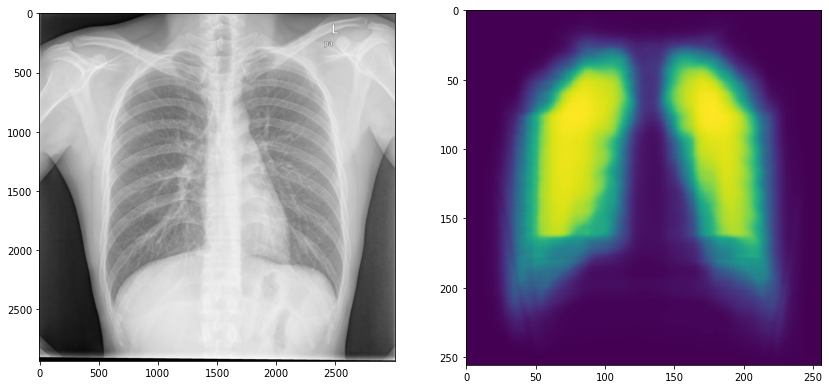

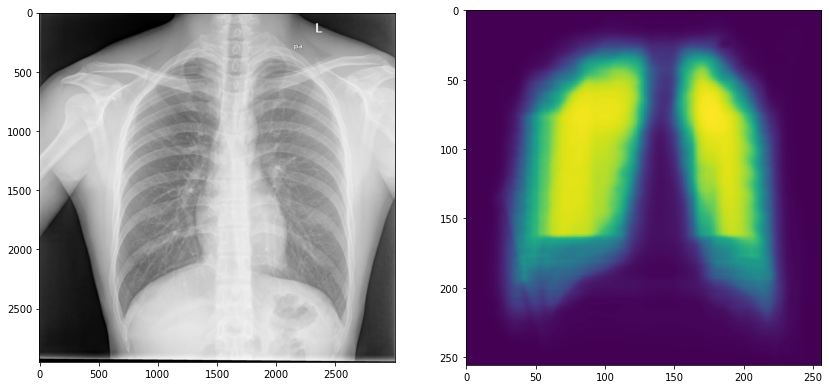

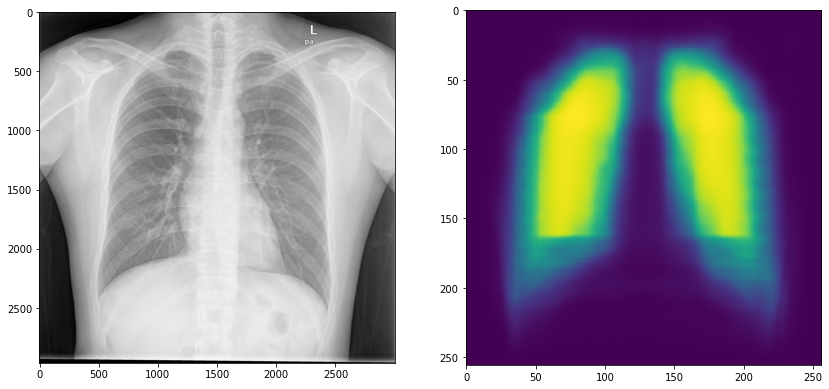

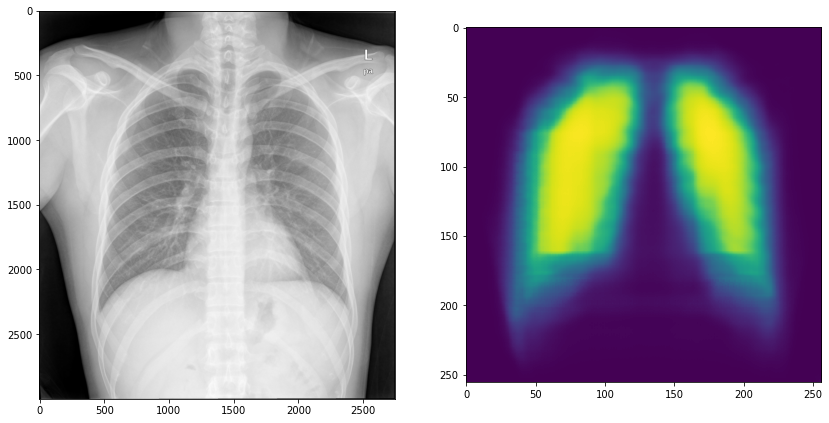

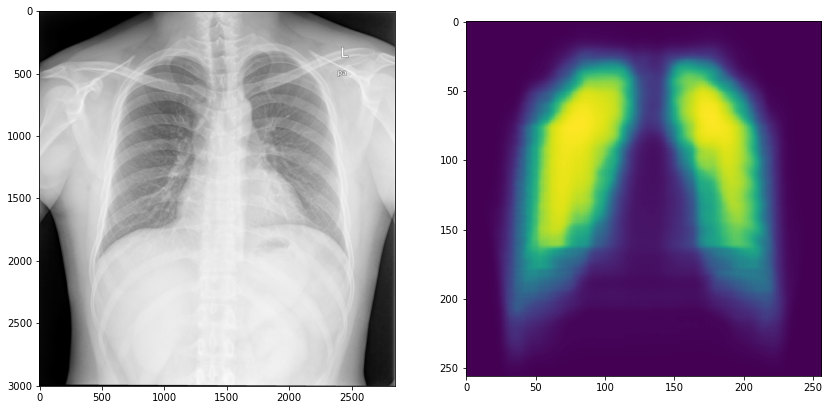

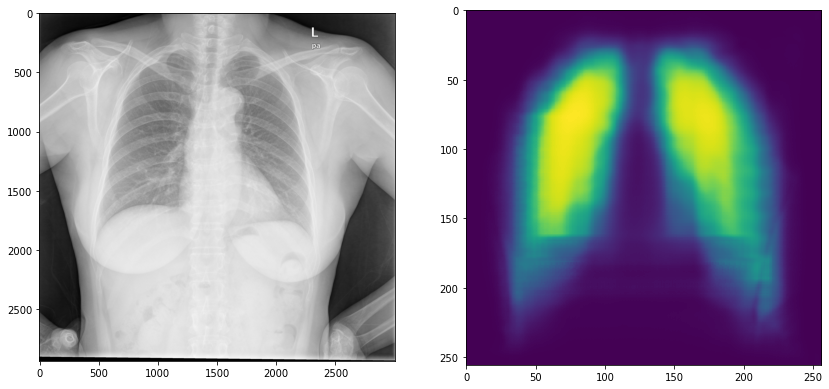

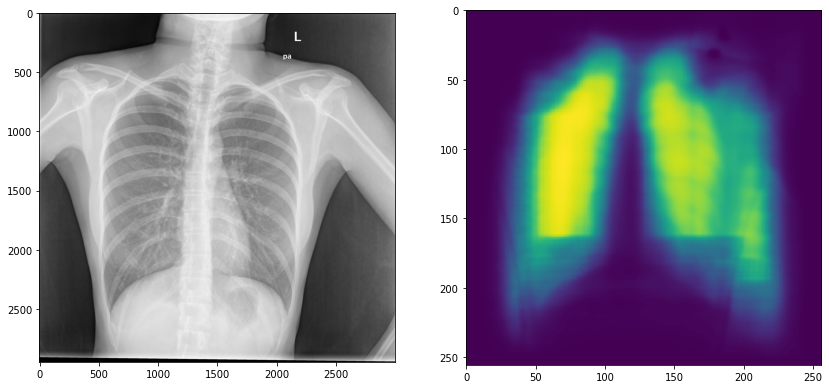

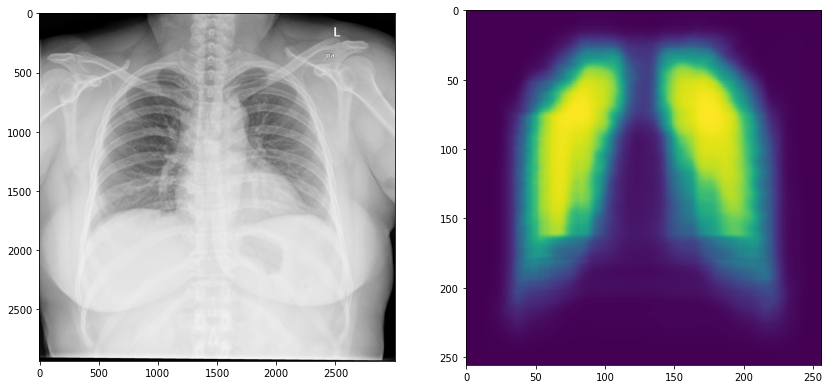

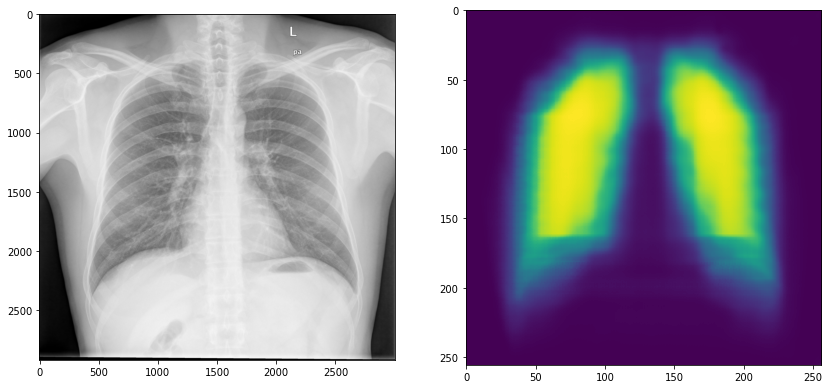

In [31]:
for dir in range(len(test_imgs_dirs)):
  fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 9))
  ax[0].imshow(cv2.imread(test_imgs_dirs[dir]))
  ax[1].imshow(get_segmentation(loaded_model, test_imgs_dirs, dir))
  if dir > 7:
    break